***Installing torch***

In [ ]:
!pip3 install torch==1.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.1+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2)
ERROR: No matching distribution found for torch==1.9.1+cu111


In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#IMPORTING LIBRARIES

In [ ]:
#importing all the required libraries
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
from skimage.util import random_noise
import os

# PyTorch libraries and modules
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# from sklearn.metrics import accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Downloading colour images from BSD Dataset and preparing the dataset

In [ ]:
#Mount GDrive for reading images stored in GDrive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Images taken from mentioned url called training images
# Get image names from a GDrive directory

trainpath = "/content/gdrive/MyDrive/BSDS300/images/train/"

imageNames = []                     #Creating an empty list to store image names
for i in os.listdir(trainpath):          #Looping over the all images in path
  imageNames.append(i)         #appending it empty list with name imageNames

imageNames.sort()
print(imageNames, len(imageNames), sep="\n")

['100075.jpg', '100080.jpg', '100098.jpg', '103041.jpg', '104022.jpg', '105019.jpg', '105053.jpg', '106020.jpg', '106025.jpg', '108041.jpg', '108073.jpg', '109034.jpg', '112082.jpg', '113009.jpg', '113016.jpg', '113044.jpg', '117054.jpg', '118020.jpg', '118035.jpg', '12003.jpg', '12074.jpg', '122048.jpg', '124084.jpg', '126039.jpg', '130034.jpg', '134008.jpg', '134052.jpg', '135037.jpg', '135069.jpg', '138032.jpg', '138078.jpg', '140055.jpg', '140075.jpg', '144067.jpg', '145014.jpg', '145053.jpg', '147021.jpg', '147062.jpg', '15004.jpg', '15088.jpg', '151087.jpg', '153077.jpg', '153093.jpg', '155060.jpg', '156079.jpg', '157036.jpg', '159029.jpg', '159045.jpg', '159091.jpg', '16052.jpg', '161062.jpg', '163014.jpg', '163062.jpg', '164074.jpg', '166081.jpg', '169012.jpg', '170054.jpg', '172032.jpg', '173036.jpg', '176019.jpg', '176035.jpg', '176039.jpg', '178054.jpg', '181018.jpg', '181079.jpg', '181091.jpg', '183055.jpg', '183087.jpg', '187003.jpg', '187029.jpg', '187039.jpg', '187071.jp

#MODEL DEEP CNN

## Dataset generation

a.  Largest Odd window size = 13

b. Blur kernels and noise kernels used :


*   Blur from cv2 with a kernel of 5x5


*   Noise kernel of salt and pepper noise which has a variance of 0.2

c. One image is loaded from the folder of images (11th image in the train images), blur and noise kernels were applied. Then 27x27 patches from this degraded image with a max. no: of 10000 patches were extracted and also the central pixels of each patch of clean image are stored.

(321, 481, 3)


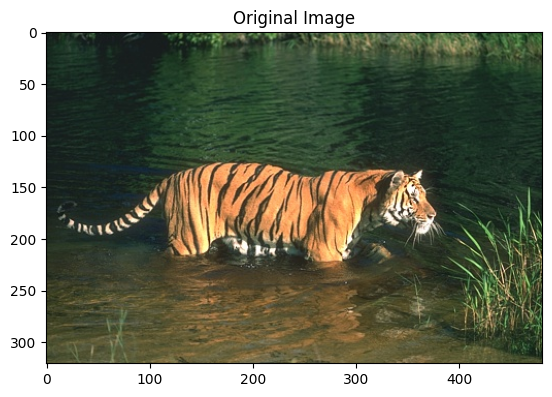

In [ ]:
# Read one image and display it
from matplotlib import image
imageNum = 10 # Eleventh image in the directory will be read

img = image.imread(trainpath+imageNames[imageNum]) # Read image

plt.imshow(img)
plt.title("Original Image")
print(img.shape)

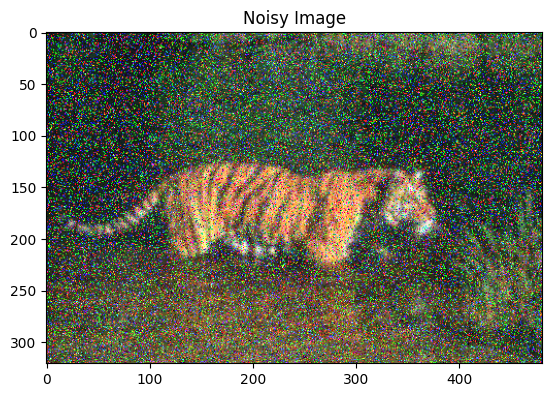

In [ ]:
#Lets check extent of our noise
# Print image attributes
blur_img= cv2.blur(img, (5,5)) #Blurring image using appropriate kernel

# Add salt-and-pepper noise to the image.
noise_img = random_noise(blur_img, mode='s&p',amount=0.2)

# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')


plt.imshow(noise_img)
plt.title("Noisy Image")
plt.show()

**Lets make 10000 patches of Noisy image as our input to CNN**

In [ ]:
from sklearn.feature_extraction import image
x_train = image.extract_patches_2d(noise_img, (27, 27), max_patches=10000)
print('Patches shape: {}'.format(x_train.shape))

Patches shape: (10000, 27, 27, 3)


In [ ]:
x_train = x_train / 255
x_train = x_train.astype('float32')

In [ ]:
x_train = np.array(x_train)
print(type(x_train),x_train.shape )

<class 'numpy.ndarray'> (10000, 27, 27, 3)


**Targeted output preparation, patches of clean image to get central pixel.**

In [ ]:
from sklearn.feature_extraction import image
imgpatch = image.extract_patches_2d(img, (27, 27), max_patches=10000)
print('Patches shape: {}'.format(imgpatch.shape))

Patches shape: (10000, 27, 27, 3)


**Get central pixel**

In [ ]:
cent_patch=[]
for i in range (len(imgpatch)):
  j= imgpatch[i, 13, 13, 0:3]
  cent_patch.append(j)

In [ ]:
y_train= np.array(cent_patch)
y_train = y_train / 255
y_train = y_train.astype('float32')
print(type(y_train), y_train.shape)

<class 'numpy.ndarray'> (10000, 3)


In [ ]:
y_train= y_train.reshape(10000,1,1,3)
print(y_train.shape)
# print(y_train[0])


(10000, 1, 1, 3)


In [ ]:
print(y_train[:5])


[[[[0.9137255  0.6509804  0.44705883]]]


 [[[0.10196079 0.16862746 0.12941177]]]


 [[[0.24313726 0.22352941 0.14509805]]]


 [[[0.88235295 0.54901963 0.3254902 ]]]


 [[[0.30980393 0.3882353  0.24313726]]]]


**Lets keep 10% data in the validation set and the remaining in the training set.**

In [ ]:
from sklearn.model_selection import train_test_split

# create validation set
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((9000, 27, 27, 3), (9000, 1, 1, 3)), ((1000, 27, 27, 3), (1000, 1, 1, 3)))

In [ ]:
# converting training images into torch format
train_x = train_x.reshape(9000, 3, 27, 27)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.reshape(9000, 3, 1, 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([9000, 3, 27, 27]), torch.Size([9000, 3, 1, 1]))

In [ ]:
# converting validation images into torch format
val_x = val_x.reshape(1000, 3, 27, 27)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.reshape(1000, 3, 1, 1);
val_y = torch.from_numpy(val_y)
# val_y = torch.tensor(val_y, dtype= torch.long)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([1000, 3, 27, 27]), torch.Size([1000, 3, 1, 1]))

**Lets define model architecture**

In [ ]:
class NewNet(nn.Module):
  def __init__(self):
    super(NewNet,self).__init__()
    self.c1 = nn.Conv2d(3,8,9)       #kernel size for each layer is choosen such that
    # self.c2 = nn.conv2d(8,8,11)    # Out of last Cnn layer matches with our targeted output.
    self.p1 = nn.BatchNorm2d(8)
    self.c2 = nn.Conv2d(8,16,7)
    self.p2 = nn.BatchNorm2d(16)
    self.c3 = nn.Conv2d(16,32,5)
    self.p3 = nn.BatchNorm2d(32)
    self.c4 = nn.Conv2d(32,64,5)
    self.p4 = nn.BatchNorm2d(64)
    self.c5 = nn.Conv2d(64,128,3)
    self.p5 = nn.BatchNorm2d(128)
    self.c6 = nn.Conv2d(128,3,3)
    self.p6 = nn.BatchNorm2d(3)
    self.c7 = nn.Conv2d(3,3,1)
    self.drop = nn.Dropout2d(p=0.25)

  def forward(self,x):
    x = self.p1(F.relu(self.c1(x)))
    x = self.drop(x)
    x = self.p2(F.relu(self.c2(x)))
    x = self.p3(F.relu(self.c3(x)))
    x = self.drop(x)
    x = self.p4(F.relu(self.c4(x)))
    x = self.p5(F.relu(self.c5(x)))
    x = self.drop(x)
    x = self.p6(F.relu(self.c6(x)))

    x = self.c7(x)
    return x

test_model = NewNet().to(device)

**Sumary of our model**

In [ ]:
from torchsummary import summary
summary(test_model, (3,27,27))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 19, 19]           1,952
       BatchNorm2d-2            [-1, 8, 19, 19]              16
         Dropout2d-3            [-1, 8, 19, 19]               0
            Conv2d-4           [-1, 16, 13, 13]           6,288
       BatchNorm2d-5           [-1, 16, 13, 13]              32
            Conv2d-6             [-1, 32, 9, 9]          12,832
       BatchNorm2d-7             [-1, 32, 9, 9]              64
         Dropout2d-8             [-1, 32, 9, 9]               0
            Conv2d-9             [-1, 64, 5, 5]          51,264
      BatchNorm2d-10             [-1, 64, 5, 5]             128
           Conv2d-11            [-1, 128, 3, 3]          73,856
      BatchNorm2d-12            [-1, 128, 3, 3]             256
        Dropout2d-13            [-1, 128, 3, 3]               0
           Conv2d-14              [-1, 

**Parameter Initialization**

In [ ]:
# defining the model
model = NewNet().to(device)

# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)  # Adam Optamizer

criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

NewNet(
  (c1): Conv2d(3, 8, kernel_size=(9, 9), stride=(1, 1))
  (p1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
  (p2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (p3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (p4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (p5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c6): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1))
  (p6): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c7): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (drop): Dropout2d(p=0.25, inplace=False)
)


**Lets train our model**

In [ ]:
#Lets define function to train the model
def train(epoch):
  model.train()
  tr_loss=0
  #get training set
  x_train_, y_train_=  Variable(train_x), Variable(train_y)

  #get validation set
  x_val, y_val = Variable(val_x), Variable(val_y)

  #For GPU
  if torch.cuda.is_available():
    x_train_ = x_train_.cuda()
    y_train_ = y_train_.cuda()
    x_val = x_val.cuda()
    y_val = y_val.cuda()

  # clearing the Gradients of the model parameters
  optimizer.zero_grad()

  # prediction for training and validation set
  output_train = model(x_train_)
  output_val = model(x_val)

  # computing the training and validation loss
  loss_train = criterion(output_train, y_train_)
  loss_val = criterion(output_val, y_val)
  train_losses.append(loss_train)
  val_losses.append(loss_val)

  # computing the updated weights of all the model parameters
  loss_train.backward()
  optimizer.step()
  tr_loss = loss_train.item()

  print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

**Training for 50 epochs**

In [ ]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
  train(epoch)

Epoch :  1 	 loss : tensor(0.4040, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  2 	 loss : tensor(0.1590, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  3 	 loss : tensor(0.0809, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  4 	 loss : tensor(0.0456, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  5 	 loss : tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  6 	 loss : tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  7 	 loss : tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  8 	 loss : tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  9 	 loss : tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  10 	 loss : tensor(0.0360, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  11 	 loss : tensor(0.0338, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  12 	 loss : tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch :  13 	 loss : tensor(0.0308, d

In [ ]:
# print(train_losses)
# print(val_losses)
train_losses1 = [train_losses[i].to(device).detach().cpu().numpy() for i in range(len(train_losses))]
val_losses1 = [val_losses[i].to(device).detach().cpu().numpy() for i in range(len(val_losses))]
# print(train_losses1)
# plt.plot(train_losses1, label='Training loss')

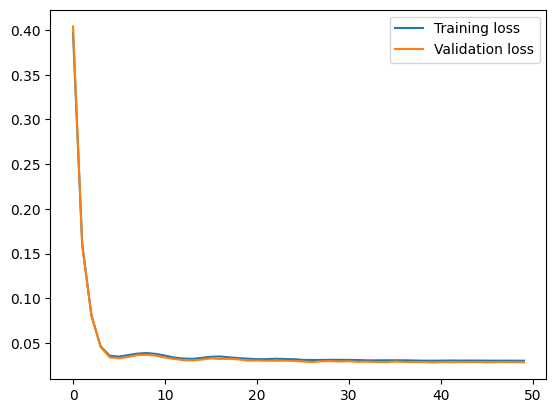

In [ ]:
# plotting the training and validation loss
# train_losses = train_losses.to(device)
plt.plot(train_losses1, label='Training loss')
plt.plot(val_losses1, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
#SAVING FINAL MODEL

PATH2 = '/content/gdrive/MyDrive/Finalcnn.pth'
torch.save(model.state_dict(), PATH2)

In [ ]:
#loading ptocedure from path
model = NewNet()
model.load_state_dict(torch.load(PATH2))

<All keys matched successfully>

**Lets see how our  model has performed by calculating MSE on training and validation set**

In [ ]:
# prediction for training set
with torch.no_grad():
    output = model(train_x)
predictions = output.cpu()

# accuracy on training set
print("MSE on trainset is: ", criterion(train_y, predictions))

MSE on trainset is:  tensor(0.0302)


In [ ]:
# prediction for val set
with torch.no_grad():
    output = model(val_x)
predictions = output.cpu()

# accuracy on training set
print("MSE on val set is: ", criterion(val_y, predictions))

MSE on val set is:  tensor(0.0285)


**Prepare data that model has never seen**

(321, 481, 3)


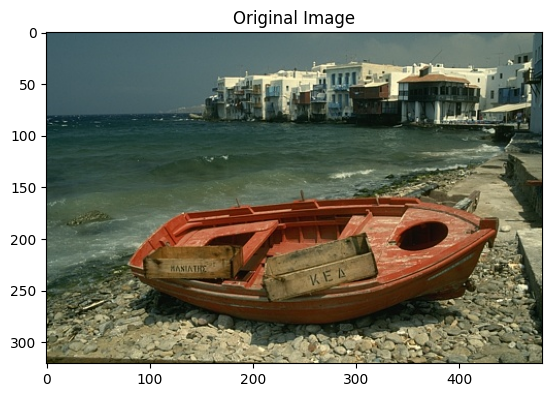

In [ ]:
# Read one image and display it
from matplotlib import image
imageNum = 17 # Eleventh image in the directory will be read

img = image.imread(trainpath + imageNames[imageNum]) # Read image

plt.imshow(img)
plt.title("Original Image")
print(img.shape)

In [ ]:
img[200, 400]

array([220, 170, 137], dtype=uint8)

**Prepare x_test**

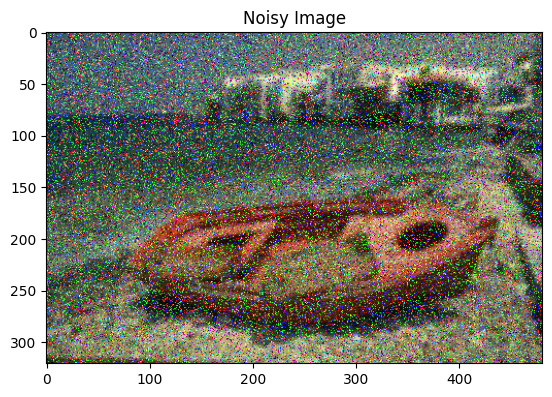

In [ ]:
#Lets check extent of our noise
# Print image attributes
blur_img= cv2.blur(img, (5,5)) #Blurring image using appropriate kernel

# Add salt-and-pepper noise to the image.
noise_img = random_noise(blur_img, mode='s&p',amount=0.2)

# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')


plt.imshow(noise_img)
plt.title("Noisy Image")
plt.show()

In [ ]:
#Get 10000 patches
from sklearn.feature_extraction import image
x_test = image.extract_patches_2d(noise_img, (27, 27), max_patches= 10000)
print('Patches shape: {}'.format(x_train.shape))
print(type(x_test))

# x_test = x_test / 255
x_test = x_test.astype('float32')
x_test = np.array(x_test)
print(type(x_test))

# converting testing images into torch format
x_test = x_test.reshape(10000, 3, 27, 27)
x_test  = torch.from_numpy(x_test)
x_test= x_test.float()

# shape of testing data
x_test.shape

Patches shape: (10000, 27, 27, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


torch.Size([10000, 3, 27, 27])

**Prepare Y_test**

In [ ]:
from sklearn.feature_extraction import image
ypatch = image.extract_patches_2d(img, (27, 27), max_patches= 10000)
print('Patches shape: {}'.format(x_train.shape))

cent_patch=[]
for i in range (len(ypatch)):
  j= imgpatch[i, 13, 13, 0:3]
  cent_patch.append(j)

y_test= np.array(cent_patch)
y_test = y_test / 255
y_test = y_test.astype('float32')
print(type(y_test))

# converting testing images into torch format
y_test = y_test.reshape(10000, 3, 1, 1)
y_test  = torch.from_numpy(y_test)
y_test= y_test.float()

# shape of testing data
y_test.shape

Patches shape: (10000, 27, 27, 3)
<class 'numpy.ndarray'>


torch.Size([10000, 3, 1, 1])

**Lets fit new data x_test to model**

In [ ]:
test_out = model(x_test)

In [ ]:
test_out.shape

torch.Size([10000, 3, 1, 1])

In [ ]:
# accuracy on test set
# test_out= test_out.cpu()
print("Model MSE on test data is: ", criterion(y_test, test_out))

Model MSE on test data is:  tensor(0.0301, grad_fn=<MseLossBackward0>)


**MSE is decent for a CNN Model which is expected to perform better for image regression.**